In [2]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
from Sparse_vector.sparse_vector import SparseVector

In [4]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('data_hg_19/hg19_features/') if i.endswith('.pkl')]

In [5]:
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features if (i.split('_')[0] in groups)]

def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'data_hg_19/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"data_hg_19/hg19_dna/{file}") for file in files])

In [6]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}
ZDNA = load('data_hg_19/hg19_zdna/ZDNA.pkl')

DNA_features = {feture: load(f'data_hg_19/hg19_features/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

CPU times: user 14.9 s, sys: 6.25 s, total: 21.1 s
Wall time: 21.4 s


In [7]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [8]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels_source, intervals, lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.lrp_feat = lrp_feat
        
    def __len__(self):
        return len(self.intervals)
    
    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(lrp_feat)]
        
        return (X, y)
        
        

In [9]:
width =5000

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chroms:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████| 3/3 [00:00<00:00, 10894.30it/s]


In [10]:
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

In [11]:
train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem 
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]



train_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [12]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from IPython.display import clear_output
class ImageZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),
                    nn.Conv2d(3, 3, kernel_size=(5, 5), padding=2),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),
                    nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(1058, 800),
                    nn.Dropout(0.5),
                    nn.ReLU(),
                    nn.Linear(800, 600),
                    nn.Dropout(0.5),
                    nn.ReLU(),
                    nn.Linear(600, 2)
        )
    
    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1058)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [13]:
import tqdm
from sklearn.utils.class_weight import compute_class_weight

params = {'batch_size':32,
          'num_workers':2,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)
# y_all = []
# for _, (X_batch, y_batch) in enumerate(tqdm.tqdm(loader_train)):
#     y = y_batch.numpy()
#     y_all += list(y)
# y_all1 = []
# for i in y_all:
#     y_all1 += list(i)
    
# class_weights=compute_class_weight(class_weight  = 'balanced',classes = np.unique(y_all1),y = y_all1)
# class_weights=torch.tensor(class_weights,dtype=torch.float)


def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)
    
# def loss_func(output, y_batch):
#     return torch.nn.NLLLoss(weight = class_weights.cuda())(torch.transpose(output, 2, 1), y_batch)



def train_epoch(model, optimizer):
    loss_log, acc_log, roc_auc_log, f1_log, pr_log = [], [], [], [], []
    model.train()
    for _, (X_batch, y_batch) in enumerate(tqdm.tqdm(loader_train)):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten()
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            pr = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
            pr = average_precision_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        pr_log.append(pr)

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log, pr_log

def test(model):
    loss_log, acc_log, roc_auc_log, f1_log, pr_log = [], [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in loader_test:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        pred = torch.argmax(output, dim=2)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            pr = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
            pr = average_precision_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))
        pr_log.append(pr)
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log, pr_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=27):
    plt.figure(figsize=(epoch_to_show, 5))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='grey', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='magenta', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log, train_auc_log, train_f1_log, train_pr_log = [], [], [], [], []
    val_log,   val_acc_log,   val_auc_log, val_f1_log, val_pr_log  = [], [], [], [], []
    
    for epoch in range(n_epochs):
        best_models = []
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_loss, train_acc, train_auc, train_f1, train_pr = train_epoch(model, opt)
        val_loss, val_acc, val_auc, val_f1, val_pr = test(model)
        
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)
        train_pr_log.extend(train_pr)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        val_pr_log.append(np.mean(val_pr))
        
        if (epoch % 1) == 0:
            clear_output()
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'AUC-ROC',      BatchSize)
            plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
            
            
            print("Epoch {} AUC-ROC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            print("Epoch {} Accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            print("Epoch {} F1-score = {:.2%}".format(epoch+1, val_f1_log[-1]))
            display(pd.DataFrame({'epoch': np.arange(epoch + 1) + 1, 'AUC-ROC':val_auc_log,
                                'F1-score':val_f1_log  }))


            
            
    print("Final AUC: {:.2}".format(val_auc_log[-1]))
    print("Final accuracy: {:.2}".format(val_acc_log[-1]))
    print("Final F1-score: {:.2}".format(val_f1_log[-1]))
    return best_models

In [14]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [15]:
model = ImageZ()
model= nn.DataParallel(model)
model = model.cuda()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 1329302


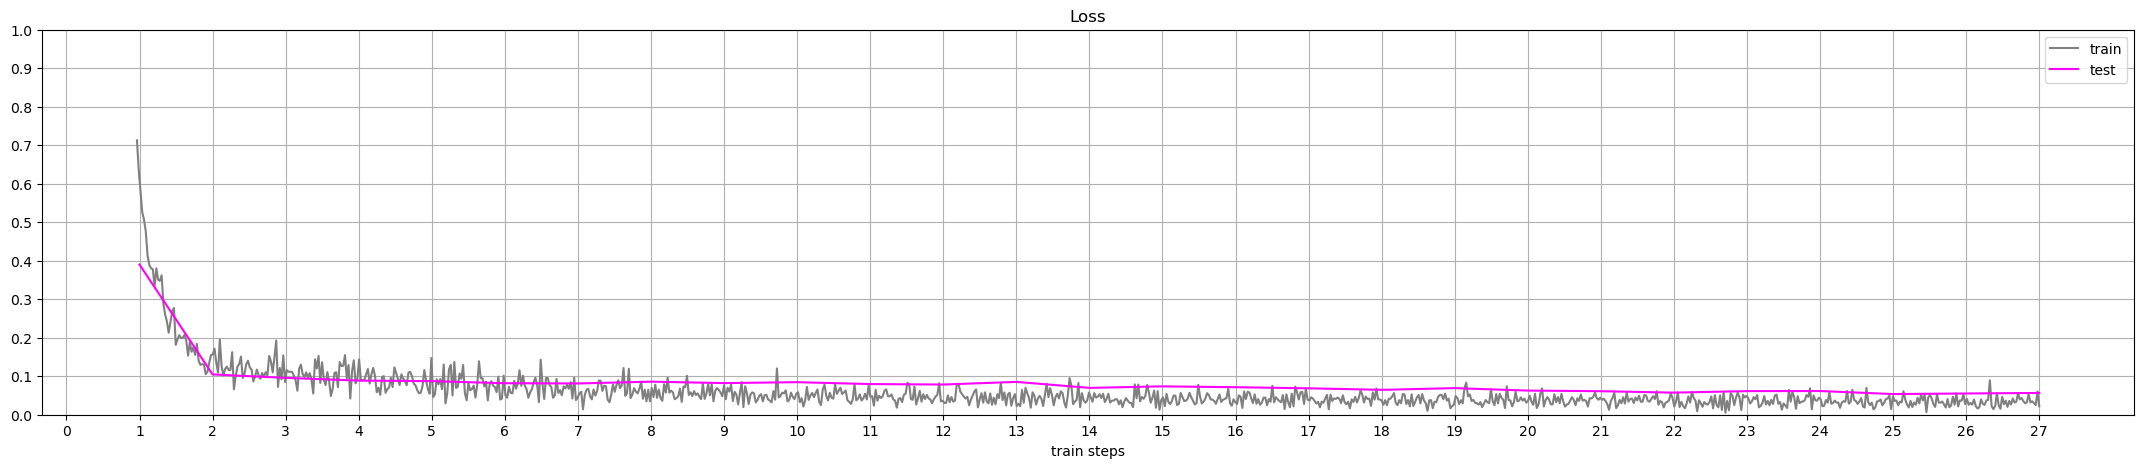

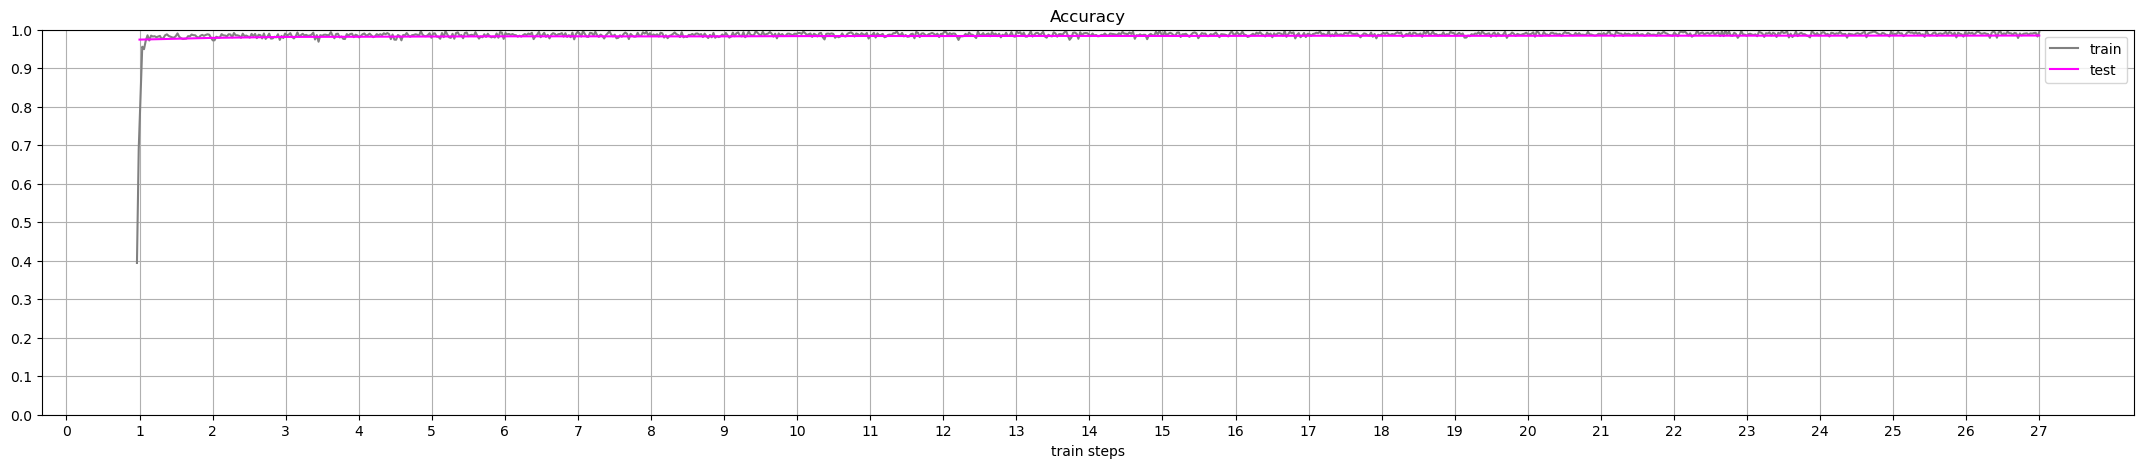

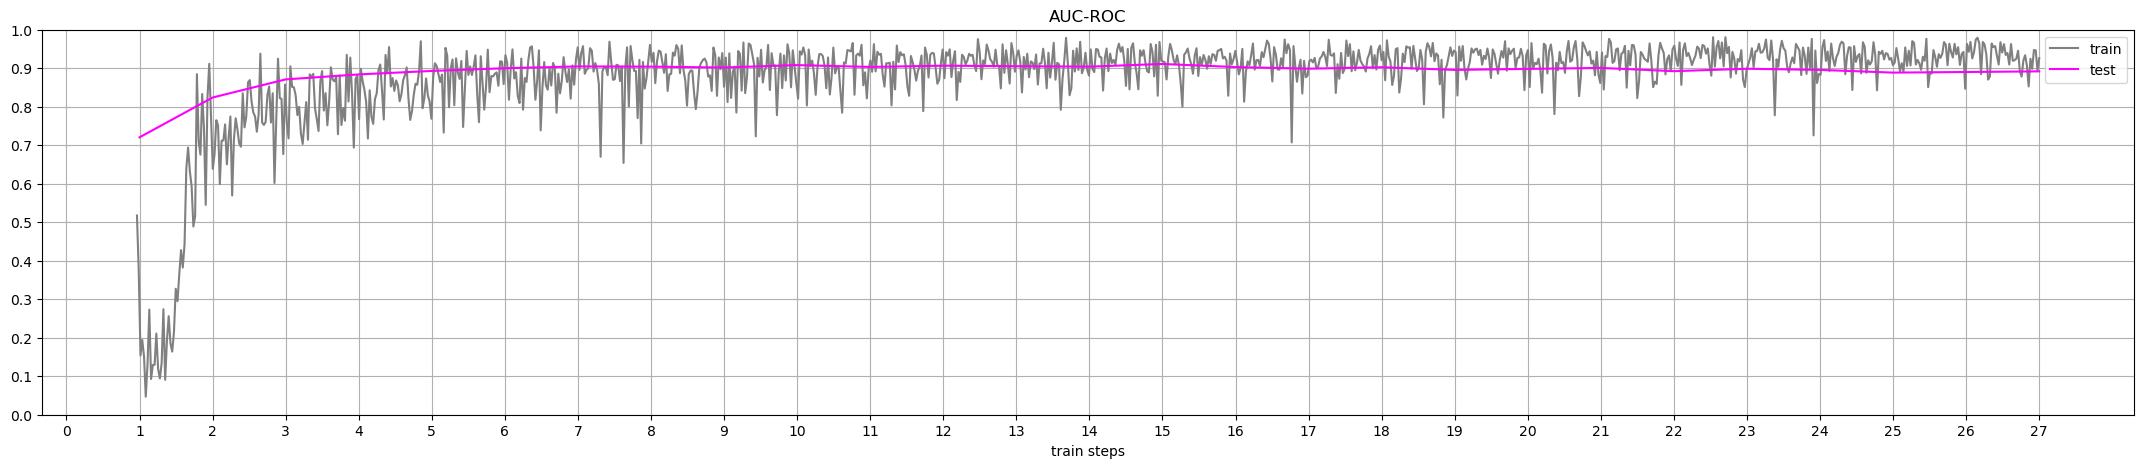

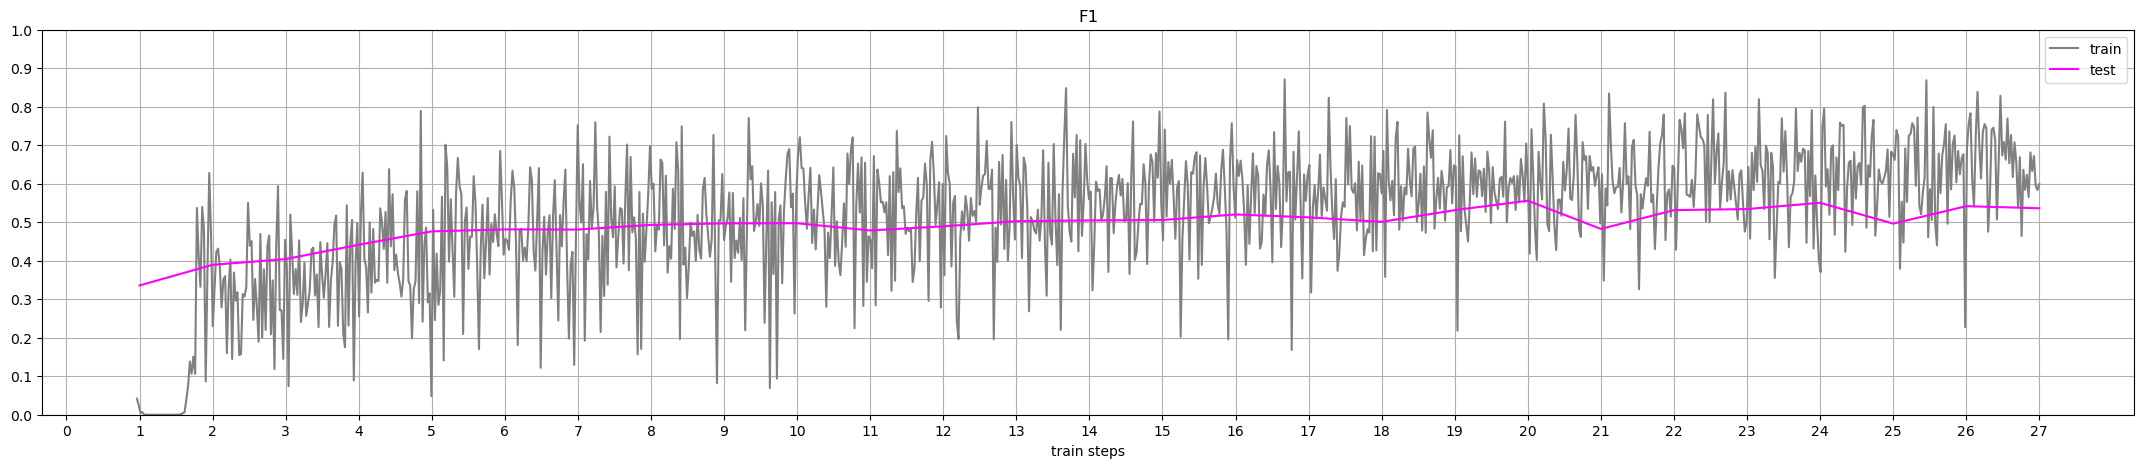

Epoch 27 AUC-ROC = 89.18%
Epoch 27 Accuracy = 98.49%
Epoch 27 F1-score = 53.62%


,epoch,AUC-ROC,F1-score
0,1,0.720475,0.335824
1,2,0.823853,0.389314
2,3,0.870980,0.404277
3,4,0.883925,0.441520
4,5,0.892926,0.476241
5,6,0.899972,0.481322
6,7,0.904657,0.480969
7,8,0.904095,0.493115
8,9,0.901878,0.496985
9,10,0.908084,0.497336


Final AUC: 0.89
Final accuracy: 0.98
Final F1-score: 0.54


In [16]:
torch.cuda.empty_cache()
torch.manual_seed(13)
opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)
best_models = train(model, opt, 27)

In [ ]:
from lrp import LRP
lrp_model = LRP(model)

In [ ]:
all = np.zeros((5000, 1058))
count = 0
for _, (X_batch, y_batch) in enumerate(tqdm.tqdm(loader_test)):
          x = X_batch.cuda()
          for i in range(x.shape[0]):
            count += 1
            r = lrp_model.get_features(x[i].reshape((1,1, 5000, 1058))).permute(0, 2, 3, 1).sum(dim=-1).squeeze().detach().cpu()
            all += np.array(r)
all = all / count

100%|██████████| 10/10 [01:23<00:00,  8.33s/it]


In [ ]:
r = lrp_model.get_features(x[1].reshape((1, 1, 5000, 1058)))

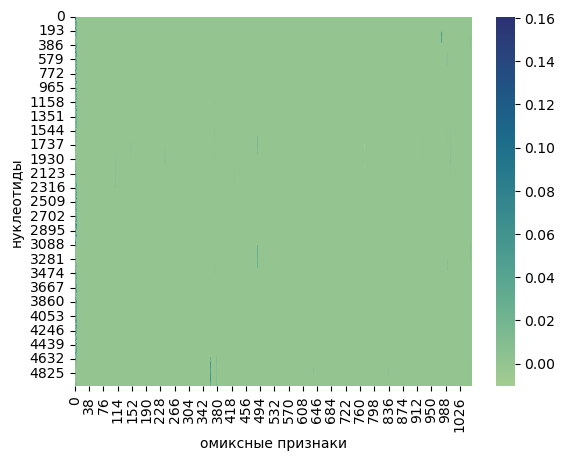

In [ ]:
ax = sns.heatmap(r.reshape(5000, 1058).cpu(), cmap="crest")
ax.set_xlabel('омиксные признаки')
ax.set_ylabel('нуклеотиды')
plt.savefig('test_h.png')

In [ ]:
data = all.mean(axis = 0)
index_1 = np.argpartition(np.abs(data), -50)[-50:]
new_feat = np.array(["A"] +  ["C"] +  ["T"] + ["G"] + all_features)
pd.DataFrame({'feat' : new_feat, 'lrp' : data}).to_csv('lrp_feat.csv', index = False)

<AxesSubplot:>

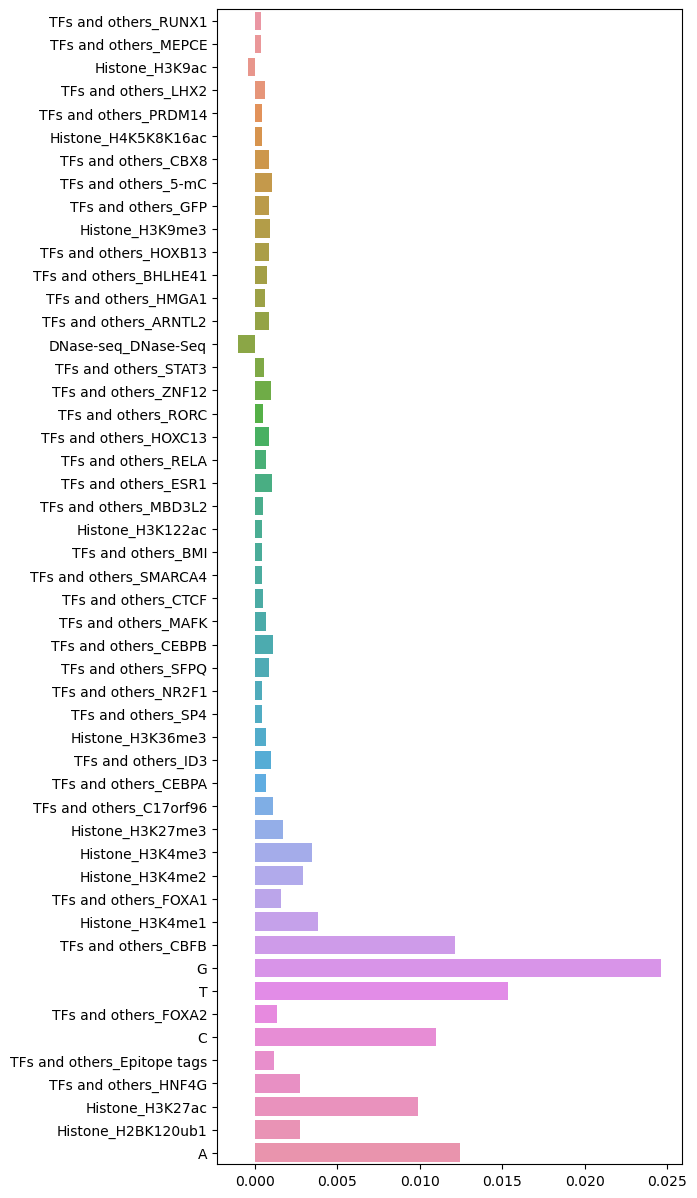

In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))
ax.set_title('омиксные признаки')
ax.set_ylabel('нуклеотиды')
sns.barplot(x=data[index_1], y=new_feat[index_1], orient='h')